# Teuko lunchbox standard comparison

__2018-05-17, Pieter-Jan Reynaert & Jochem Gietema__

This notebook replicates the [results](https://github.com/fellowship/platform-demos2/blob/master/food-tueko/Fit_Standard_Final.ipynb) of the previous cohort and compares its result to the platform.ai classification.  
In addition, this notebook will make a comparison with a different model such as the Swiss Knife model easier.  


We use a standard fastai multilabel classification setup with a custom loss function copied from the previous cohort.  
By using the various fastai 'tricks', we improve the performance of the model a little on single label classification compared to the previous cohort.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Use the [utils](https://github.com/fellowship/platform-demos2/blob/master/food-tueko/utils.py) of the previous cohort to get a nice lunchbox prediction comparison (see bottom of page).  
Just copy the file to the directory of this notebook and you will be able to import it.  
Do the same for the [fastai_multilabel](https://github.com/fellowship/platform-demos2/blob/master/food-tueko/fastai_multilabel.py) file and the [file](https://github.com/fellowship/platform-demos2/blob/master/food-tueko/focal_loss.py) that defines the focal loss.

In [2]:
from fastai.vision import *
from fastai_multilabel import *
from focal_loss import FocalFlat
import utils
from fastai_multilabel import *

The dataset comes straight from [google cloud storage](https://console.cloud.google.com/storage/browser/platform-ai-research/datasets/food/downloaded_imgs/).

In [3]:
path = Path('/home/jupyter/data/')

We first train on double label images (i.e. images with two labels such as 'banana' and 'apple').  
After that, we finetune the model on single labels.

In [4]:
train_double = 'downloaded_imgs/train_double'
train_single = 'downloaded_imgs/train_single'

In [5]:
test_dir = path/'food-teuko'

labels_double = pd.read_csv(path/'downloaded_imgs/labels_double.csv')
labels_single = pd.read_csv(path/'downloaded_imgs/labels_single.csv')

We use the [optimal transforms used by the previous cohort](https://github.com/fellowship/platform-demos2/blob/master/food-101/food101-rn50-512-90.ipynb) to reach a new state of the art on the food-101 dataset.  
Because our model contains food as well, these transforms give us a better result than using the standard transforms of fastai.

In [6]:
optimal_tfms = [RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-40.0, 40.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.4)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.35, 0.65)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 1.4285714285714286)}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmCoord (skew), kwargs={'direction': (0, 7), 'magnitude': 0.2}, p=0.75, resolved={}, do_run=True, is_random=True),
 RandTransform(tfm=TfmAffine (squish), kwargs={'scale': (0.4166666666666667, 2.4)}, p=0.75, resolved={}, do_run=True, is_random=True)]

In [7]:
ds_tfms = ([rand_crop()] + optimal_tfms, [crop_pad()])

In [8]:
data = (ImageList.from_df(labels_double, path, folder=train_double, suffix='')
        .split_by_rand_pct(valid_pct=0.1)
        .label_from_df(label_delim=' ')
        .transform(ds_tfms, size = 224)
        .databunch(bs = 32)
        .normalize(imagenet_stats))

Because we are doing multilabel classification now, we can't use the standard accuracy as a loss function.  
Instead, we use accuracy_thresh with a threshold of .6.

In [9]:
acc_02 = partial(accuracy_thresh, thresh=0.6)
f_score = partial(fbeta, thresh=0.6)

In [10]:
learn = cnn_learner(data, models.resnet50, wd=0.05, metrics=[acc_02, f_score]).to_fp16()

In [11]:
learn.loss_func = FocalFlat(gamma = 2, alpha = 100)

In [12]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


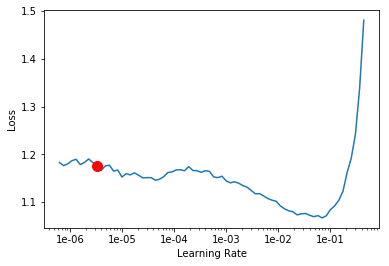

In [13]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
lr = 2e-03

In [15]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.785004,0.507737,0.688672,0.171699,01:27
1,0.552076,0.421115,0.744898,0.209890,01:27
2,0.434800,0.376935,0.799653,0.243974,01:27
3,0.389153,0.357429,0.825481,0.272968,01:27
4,0.360341,0.348238,0.848930,0.292116,01:27
5,0.349845,0.338475,0.851748,0.308470,01:27
6,0.333009,0.333126,0.865017,0.321727,01:27
7,0.321384,0.329017,0.868049,0.327751,01:27
8,0.308614,0.331784,0.877088,0.336536,01:27
9,0.302733,0.330003,0.875502,0.337241,01:27


The results are better than the previous cohort at this stage: 
- accuracy_thresh of 0.848269 vs. 0.875502
- fbeta of 0.300422 vs. 0.337241

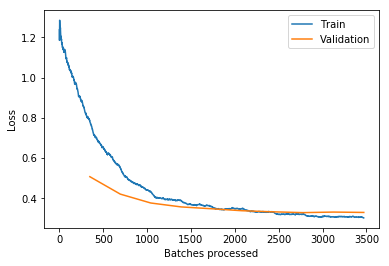

In [16]:
learn.recorder.plot_losses()

In [ ]:
learn.save('ch14-stage-1-standard-resnet50-focal-loss-wd-tfms-mp')

We now unfreeze the model and train again.

In [13]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


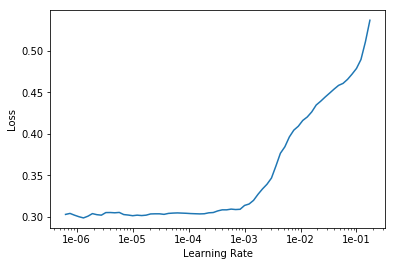

In [19]:
learn.lr_find()
learn.recorder.plot()

In [14]:
lr = 3e-5
learn.fit_one_cycle(10, slice(lr, lr*3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.308326,0.268817,0.877799,0.380790,02:06
1,0.311532,0.273366,0.883062,0.381496,02:01
2,0.310157,0.277337,0.877171,0.373910,02:01
3,0.298879,0.277052,0.879881,0.373168,02:01
4,0.285955,0.274629,0.894125,0.396697,02:01
5,0.277071,0.275227,0.893407,0.390768,02:01
6,0.263411,0.271884,0.900330,0.403307,02:02
7,0.254905,0.269690,0.903487,0.409444,02:01
8,0.248309,0.268847,0.906023,0.413762,02:01
9,0.248217,0.268176,0.903784,0.412173,02:01


The previous cohort did not plot (or committed) the results after unfreeze, so we don't have a fair estimate to compare the results at this stage of training.

In [15]:
learn.save('ch14-stage-2-standard-resnet50-focal-loss-wd-tfms-mp')

### Finetune on single labels

We now finetune the model on single label classification.

In [105]:
data = (ImageList.from_df(labels_single, path, folder=train_single, suffix='').
                split_by_rand_pct(valid_pct=0.1, seed=42). 
                label_from_df(label_delim = ' ').
                transform(get_transforms(), size = 224).
                databunch(bs = 32).
                normalize(imagenet_stats))

We use the same setup with the exception that we decrease weight decay from `0.1` to `0.05`. 

In [106]:
learn = cnn_learner(data, models.resnet50, wd=0.05, metrics=[acc_02, f_score]).load('ch14-stage-2-standard-resnet50-focal-loss-wd-tfms-mp')
learn.loss_func = FocalFlat(gamma = 2, alpha = 100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03


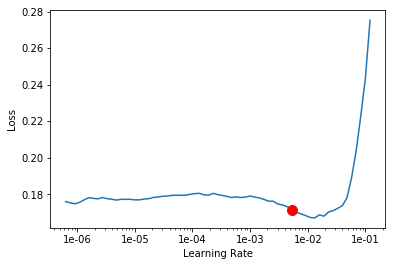

In [107]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [108]:
lr = 6e-04

In [109]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.160696,0.123903,0.953197,0.499925,01:03
1,0.122708,0.091008,0.973504,0.622730,01:03
2,0.094065,0.077587,0.976983,0.649143,01:03
3,0.079688,0.072930,0.977751,0.662344,01:03
4,0.071454,0.069610,0.978621,0.670870,01:03
5,0.063453,0.072204,0.980462,0.681728,01:03
6,0.059240,0.071126,0.981143,0.688237,01:03
7,0.057154,0.071424,0.980983,0.688262,01:03
8,0.055691,0.073666,0.982331,0.698205,01:03
9,0.053817,0.073145,0.982172,0.696976,01:03


Again, our results are a little bit better than the previous cohort here:  
- accuracy is up from 0.971986 to 0.982172
- fbeta is up from 0.606360 to 0.696976

In [110]:
learn.save('ch14-stage-1-standard-resnet50-focal-loss-single-label-finetune-wd-tfms-mp')

In [111]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


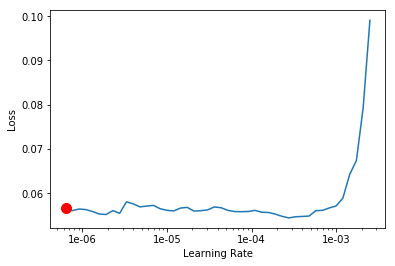

In [112]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [113]:
lr = 1e-06

In [114]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.053723,0.073336,0.982172,0.696774,01:23
1,0.054165,0.073238,0.982418,0.696373,01:24
2,0.054128,0.073588,0.982592,0.698033,01:24
3,0.053380,0.072543,0.982288,0.693976,01:24
4,0.053206,0.072137,0.982041,0.696662,01:24


The accuracy is up to 0.9872041. The previous cohort got to 0.975454 at this stage, so we improved the accuracy by more than 1 percent.

In [115]:
learn.save('ch14-stage-2-standard-resnet50-focal-loss-single-label-finetune-wd-tfms-mp')

## Interpret results

We can now interpret our results in more detail.

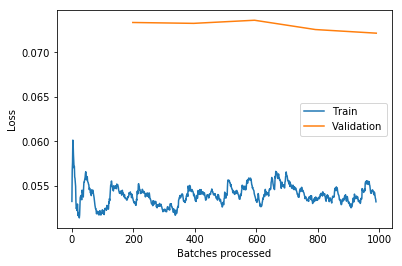

In [116]:
learn.recorder.plot_losses()

In [117]:
interp = ClassificationInterpretation.from_learner(learn)

221 misclassified samples over 704 samples in the validation set.


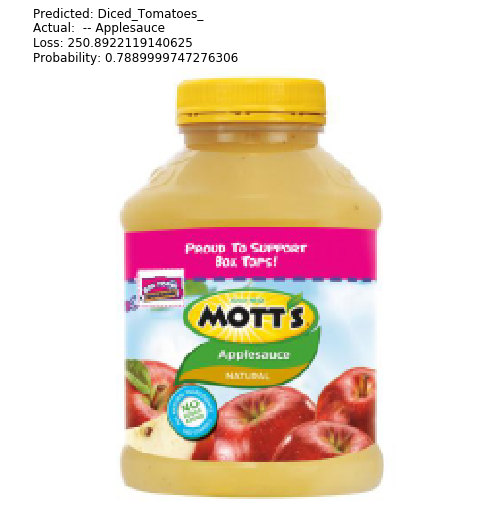

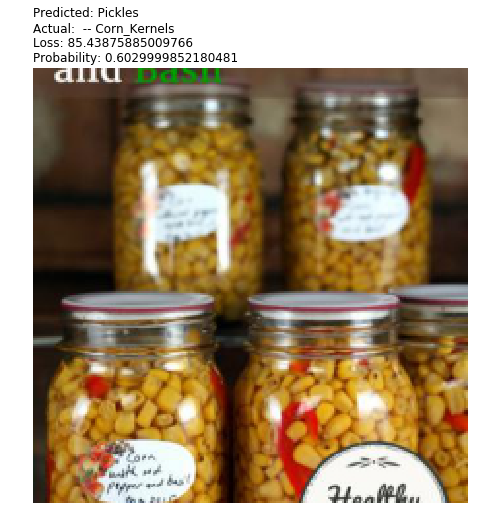

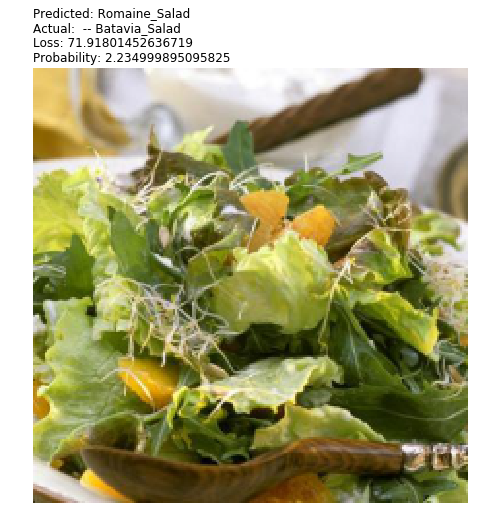

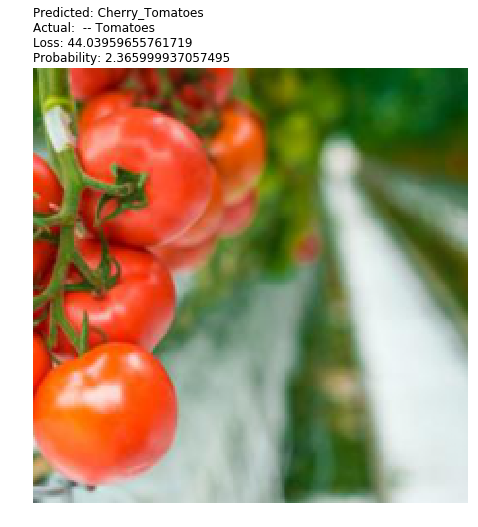

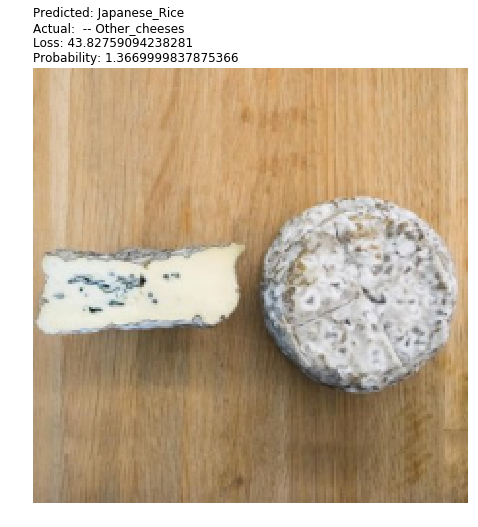

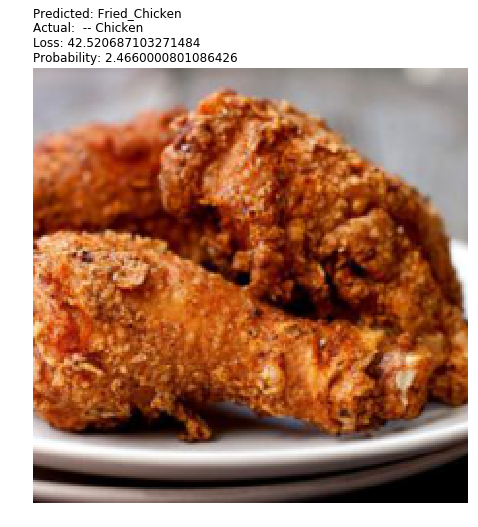

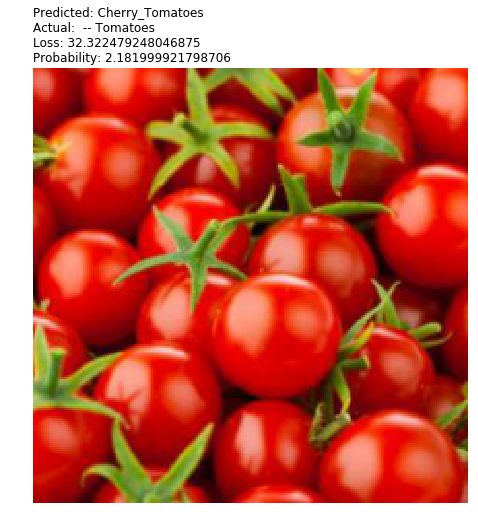

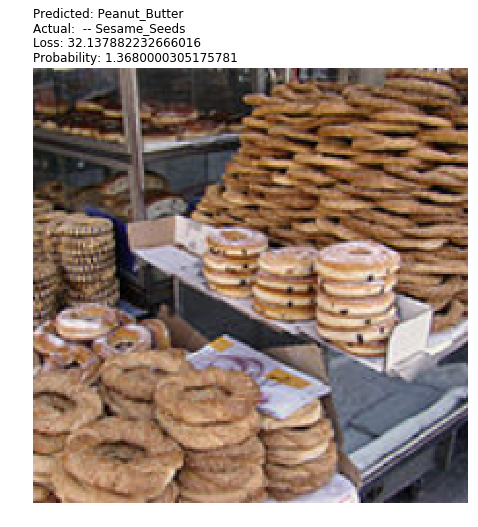

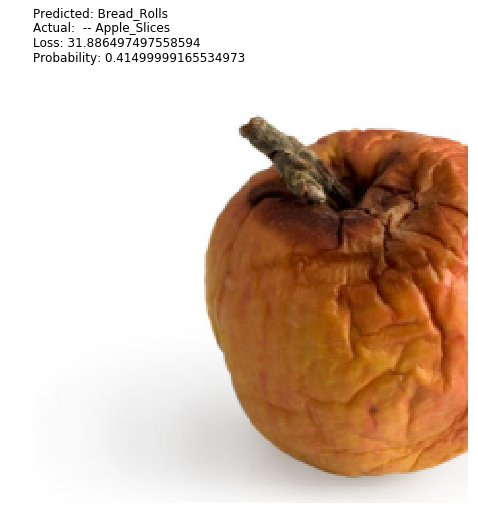

In [118]:
interp.plot_multi_top_losses(9,figsize=(8,8))

The results of this 'plot' are really interesting. More than once, the model classified an image, but was - according to the validation - too specific in its classification.
- The model classified fried chicken as fried chicken, but the image was just labeled 'chicken'
- The model classified an image of cherry tomatoes as 'cherry tomatoes', the 'correct' label was just 'tomatoes'

Other experiments showed the similar results, e.g., hard boiled eggs where labeled as hard boiled egg, the actual label was 'egg'.

It will be difficult to avoid these mistakes with our current dataset.  
We could label generic classes to more specific classes by hand or merge specific classes into the more generic classes.

In [119]:
interp = ClassificationInterpretation_Multi.from_learner(learn, sigmoid=True, top_k=5)
interp.print_overall_perf()

Looking at top 5 predictions to evaluate performance

Micro-averaged scores:
Overall F2 Score: 0.5224116161616162
Overall Recall: 0.9403409090909091
Overall Precision: 0.18806818181818183


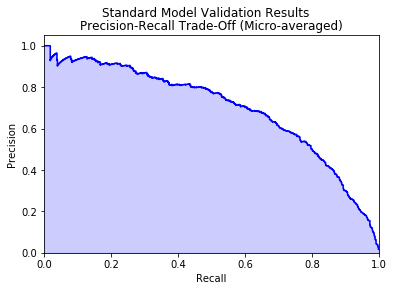

In [120]:
interp.plot_precision_recall_curve(save_fig = True,  
                                   suptitle='Standard Model Validation Results')

In [121]:
results = interp.most_confused()
results.head()

,Class,Precision,Recall,F2
31,Couscous_Crackers,0.020833,0.333333,0.083333
35,Cucumber_Dices,0.024390,0.500000,0.102041
12,Beef_sausage,0.030303,1.000000,0.135135
46,Grated_Parmesan,0.092593,0.625000,0.290698
44,Grapes,0.078431,1.000000,0.298507


In [122]:
results.tail()

,Class,Precision,Recall,F2
61,Omelette,0.428571,1.0,0.789474
6,Babybel,0.437500,1.0,0.795455
90,Strawberries,0.461538,1.0,0.810811
14,Blueberries,0.461538,1.0,0.810811
18,Broccoli,0.470588,1.0,0.816327


In [123]:
interp.get_preds(top_k=3)
interp.print_overall_perf()

Looking at top 3 predictions to evaluate performance

Micro-averaged scores:
Overall F2 Score: 0.6290584415584415
Overall Recall: 0.8806818181818182
Overall Precision: 0.2935606060606061


In [124]:
lunchboxes = path / 'lunchboxes/'

Showing top 10 predictions. 

Raspberries: 71.1%
Romaine_Salad: 63.9%
Sandwich: 63.6%
Pork: 55.3%
Salad: 52.3%
Ground_Beef: 48.5%
Fruity_Yogurt: 46.5%
Lettuce_Salad_: 45.9%
Asparagus: 45.0%
Strawberries: 43.8%


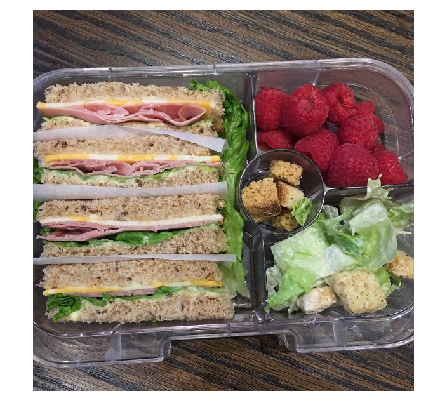

In [138]:
utils.show_predictions(lunchboxes.ls()[random.randint(0,100)], learn, sigmoid=True)

One problem we have here is that quite a few predicted labels are perfectly correct, 
We're confident that adding more data here will increase the confidence of the predictions. 